# Your Title Information Goes Here
Fill me in

## Setup

In [284]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`


   Resolving package versions...


  No Changes to `C:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23\Project.toml`
  No Changes to `C:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23\Manifest.toml`


  Activating project at `c:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23`


  No Changes to `C:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23\Project.toml`
  No Changes to `C:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23\Manifest.toml`


    Updating registry at `C:\Users\af\.julia\registries\General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`


  No Changes

 to `C:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23\Project.toml`
  No Changes to `C:\Users\af\Documents\GitHub\CHEME-5660-Project-Template-F23\Manifest.toml`


## Section A : Prerequisites

### [1] Load historical dataset, compute expected returns and get 2023 `SPY` data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [285]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-12-01-2023.jld2")) |> x-> x["dataset"];

original_dataset["AAPL"] # Testing Checkpoint

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,1.17982e8,43.2781,43.1325,43.0575,43.6375,42.99,2018-01-03T05:00:00,188333
2,8.97384e7,43.2473,43.135,43.2575,43.3675,43.02,2018-01-04T05:00:00,153150
3,9.46401e7,43.6732,43.36,43.75,43.8425,43.2625,2018-01-05T05:00:00,152173
4,8.22711e7,43.6581,43.5875,43.5875,43.9025,43.4825,2018-01-08T05:00:00,138842
5,8.6336e7,43.5803,43.6375,43.5825,43.765,43.3525,2018-01-09T05:00:00,154006
6,9.58396e7,43.4126,43.29,43.5725,43.575,43.25,2018-01-10T05:00:00,151201
7,7.46709e7,43.7894,43.6475,43.82,43.8722,43.6225,2018-01-11T05:00:00,117864
8,9.68123e7,44.1806,44.045,44.2725,44.34,43.9125,2018-01-12T05:00:00,151952
9,1.18128e8,44.3672,44.475,44.0475,44.8475,44.035,2018-01-16T05:00:00,195534


### [2] Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [286]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [287]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset # Testing Checkpoint

Dict{String, DataFrame} with 459 entries:
  "NI"   => 1489×8 DataFrame…
  "EMR"  => 1489×8 DataFrame…
  "CTAS" => 1489×8 DataFrame…
  "HSIC" => 1489×8 DataFrame…
  "KIM"  => 1489×8 DataFrame…
  "PLD"  => 1489×8 DataFrame…
  "IEX"  => 1489×8 DataFrame…
  "BAC"  => 1489×8 DataFrame…
  "CBOE" => 1489×8 DataFrame…
  "EXR"  => 1489×8 DataFrame…
  "NCLH" => 1489×8 DataFrame…
  "CVS"  => 1489×8 DataFrame…
  "DRI"  => 1489×8 DataFrame…
  "DTE"  => 1489×8 DataFrame…
  "ZION" => 1489×8 DataFrame…
  "AVY"  => 1489×8 DataFrame…
  "EW"   => 1489×8 DataFrame…
  "EA"   => 1489×8 DataFrame…
  "NWSA" => 1489×8 DataFrame…
  ⋮      => ⋮

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [288]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### [3] Get the 2023 `SPY` data

In [289]:
startdate = Date(2023,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

### [4] Compute the expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [290]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = 0.0);
all_firms_return_matrix # Testing Checkpoint

1488×459 Matrix{Float64}:
  0.374988   1.92928    7.02769   …   5.80159    1.79882    2.05452
  2.18987   -0.618139   4.02037       4.00668   -0.711936   2.9759
  0.936321  -1.91617   -0.803754      2.89928   -0.355978   2.46921
  6.20162    1.51203   -1.87102       6.60558    5.1484     3.41373
 -3.47638    4.92131   -0.267677      1.81502    3.3669    -4.87013
 -0.32572   10.2817     2.80668   …  10.7317     2.24034    2.48203
  3.30669    9.96413    7.37109       5.85955    2.39702    3.15105
 -0.169697   1.28539   -1.51874       2.72067   -1.55483    1.107
  1.69849   -0.255863   1.95851       0.439849  -0.102035   2.84631
  0.2133     0.137904  -0.483602     -0.160856  -0.505564  -1.09091
  ⋮                               ⋱                        
  2.26723    2.1726     7.26467       3.3749    -0.512718   1.11322
 20.2293    -4.27888   -4.26492   …   1.34512   -9.76174    4.16186
  1.70818    7.19329    4.10883       4.41632    0.37683    1.33906
  2.70146   -3.27828    3.66587  

In [291]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;
μ # Testing Checkpoint

459-element Vector{Float64}:
  0.10477118518531323
 -0.23792329291831055
 -0.11878362723945904
  0.25130568798290637
  0.0616291496433946
  0.09753407212245463
  0.13203999046355291
  0.20619167164588215
  0.11801068299041018
  0.10682284992313297
  ⋮
  0.04204955516729051
  0.030591034311174593
 -0.1229546043808743
  0.07345290303676882
  0.07472583421657158
 -0.010338970697217547
  0.13979487846925523
 -0.04846036175653935
  0.1537728141463932

## Section B : Estimating Single Index Models (SIMs) from Historical Data

In [292]:
risk_free_rate = 0.05;

Computing the excess return for all the tickers

In [293]:
all_firms_excess_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate)

1488×459 Matrix{Float64}:
  0.324988   1.87928     6.97769   …   5.75159    1.74882    2.00452
  2.13987   -0.668139    3.97037       3.95668   -0.761936   2.9259
  0.886321  -1.96617    -0.853754      2.84928   -0.405978   2.41921
  6.15162    1.46203    -1.92102       6.55558    5.0984     3.36373
 -3.52638    4.87131    -0.317677      1.76502    3.3169    -4.92013
 -0.37572   10.2317      2.75668   …  10.6817     2.19034    2.43203
  3.25669    9.91413     7.32109       5.80955    2.34702    3.10105
 -0.219697   1.23539    -1.56874       2.67067   -1.60483    1.057
  1.64849   -0.305863    1.90851       0.389849  -0.152035   2.79631
  0.1633     0.0879042  -0.533602     -0.210856  -0.555564  -1.14091
  ⋮                                ⋱                        
  2.21723    2.1226      7.21467       3.3249    -0.562718   1.06322
 20.1793    -4.32888    -4.31492   …   1.29512   -9.81174    4.11186
  1.65818    7.14329     4.05883       4.36632    0.32683    1.28906
  2.65146   -3.3282

Next, we estimate the expected excess return for each firm from the `all_firms_excess_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(R_{1}),\dotsc,\mathbb{E}(R_{N})$ in the variable $\mu$:

### Section B1 : Estimate SIM parameters for each asset in our collection

#### Estimate $\left(\alpha_{i},\beta_{i}\right)$ values for each firm
To estimate the single index model parameters, first let's initialize some storage. We'll store `MySingleIndexModel` instances for each firm in `dataset` in the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary:

In [294]:
sim_model_dictionary = Dict{String, MySingleIndexModel}();

Next, we need to pull out excess return of the `market porfolio` from `all_firms_excess_return_matrix`. To do this, lookup the index for our market portfolio surrogate `SPY`, and then get the column from the `all_firms_excess_return_matrix`:

In [295]:
index_spy = findfirst(x->x=="SPY",all_tickers);
Rₘ = all_firms_excess_return_matrix[:,index_spy];

Finally, for each `ticker` in the `all_tickers` array, compute the values for the $(\alpha,\beta)$ parameters using a `for` loop. For each iteration of the loop:
* First, look up the index of the `ticker` we are considering and store that in the `asset_ticker_index` variable. Then, store the appropriate column from `all_firms_excess_return_matrix` in the `Rᵢ` variable.
* Next, compute the number of trading days of data we have, and formulate the data array `X` and the output array `Y` for `ticker` that we will use to solve the `normal equations`.
* Finally, solve for the unknown parameter vector $\theta$, create a `MySingleIndexModel` instance for each ticker, populate the fields of this model, and store in the `sim_model_dictionary`.

In [296]:
for asset_ticker ∈ all_tickers
    
    # compute the excess return for asset_ticker -
    asset_ticker_index = findfirst(x->x==asset_ticker, all_tickers);
    Rᵢ = all_firms_excess_return_matrix[:, asset_ticker_index];
    
    # formulate the Y and X arrays with the price data -
    max_length = length(Rᵢ);
    Y = Rᵢ;
    X = [ones(max_length) Rₘ];
    
    # compute θ -
    θ = inv(transpose(X)*X)*transpose(X)*Y
    
    # package -
    sim_model = MySingleIndexModel();
    sim_model.α = θ[1];
    sim_model.β = θ[2];
    sim_model.r = risk_free_rate;
    sim_model_dictionary[asset_ticker] = sim_model;
end

### Section B2 : Compute the SIM error model for each asset in our collection
Now that we values for the $(\alpha,\beta)$ parameters for each firm, we can compute the error models. In particular, the parameters in the error can be estimated by computing the residual vector:

$$\Delta_{i} = R_{i} - \hat{R}_{i}$$

where $R_{i}$ denotes the `observed` excess return and $\hat{R}_{i}$ denotes the excess return `predicted` using the single index model. We need to do this for each firm in our `dataset` using a `for` loop. In particular, for each `ticker` in the `all_tickers` array:

* First, we get the `MySingleIndexModel` instance from `sim_model_dictionary`, and store this model in the `sim_model` variable. Then, store the appropriate column from `all_firms_excess_return_matrix` in the `Rᵢ` variable.
* Next, compute the number of trading days of data we have, access the $(\alpha, \beta)$ parameter values from `sim_model`, and compute `predicted` excess return, store this in the `R̂ᵢ` variable.
* Finally, compute the residual values $\Delta_{i} = R_{i} - \hat{R}_{i}$, fit a `Normal` distribution to the residuals using the `fit_mle(...)` function exported by [Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git), and store both the fitted distribution and residual values.

In [297]:
residual_model_dictionary = Dict{String, Array{Float64,1}}()
for asset_ticker ∈ all_tickers
    
    # grab the model -
    sim_model = sim_model_dictionary[asset_ticker];
    
    # compute the excess return for asset_ticker -
    asset_ticker_index = findfirst(x->x==asset_ticker, all_tickers);
    Rᵢ = all_firms_excess_return_matrix[:, asset_ticker_index];
    
    # what is the length -
    max_length = length(Rᵢ);
    
    # compute the model excess return -
    αᵢ = sim_model.α
    βᵢ = sim_model.β
    R̂ᵢ = αᵢ .+ βᵢ .* Rₘ
    
    # compute the residual -
    Δᵢ = Rᵢ .- R̂ᵢ;
    
    # Esimate a distribution -
    d = fit_mle(Normal, Δᵢ);
    
    # update the sim_model -
    sim_model.ϵ = d;
    
    # store the residuals -
    residual_model_dictionary[asset_ticker] = Δᵢ
end

In [298]:
sims = sim_model_dictionary;

Next let's build the `single index model` version of the covariance array. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:

$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$

where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

In [299]:
σₘ = std(all_firms_return_matrix[:, index_spy])

2.5345018373000348

We populate the single index covariance array using nested `for` loops:

In [300]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

## Section C : Computing the Efficient Frontier Collection and Selecting a Initial Portfolio

For our project we have got a grant amount of 33,052,927.28 USD, this will be our total budget

In [301]:
# initialize -
μ_sim = Array{Float64,1}();
my_list_of_firm_ids = Array{Int64,1}();
efficient_frontier_sim = Dict{Float64,Float64}();
portfolio_df = DataFrame();

total_initial_budget =  33052927.28; # Total Grant Amount
enddate::Date = Date(2023,01,03)
my_list_of_tickers = ["AAPL", "MRK", "GOOGL","AMD"] 
number_of_points = 100
maxreturn = 0.40

number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
minimum_desired_reward_array = range(0, stop = maxreturn - risk_free_rate, length = number_of_points) |> collect;


Get the ids for the tickers in my_list_of_tickers

In [302]:
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

In [303]:
R_SPY = μ[index_spy];

Compute the expected excess return for all firms

In [304]:
for i ∈ eachindex(all_tickers)

    myticker = all_tickers[i];
    sim = sims[myticker];

    αᵢ = sim.α
    βᵢ = sim.β
    Rᵢ = αᵢ+βᵢ*R_SPY

    push!(μ_sim,Rᵢ)
end

Get the μ̂_sim vector (expected excess return) for my_list_of_tickers

In [305]:
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂_sim, μ_sim[firm_index])
end

Get the Σ̂_sim matrix (covariance matrix) for my_list_of_tickers

In [306]:
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end

Build the problem object - initialize with the minimum desired excess reward, e.g., zero

In [307]:
problem_risk_sim = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂_sim,
    μ = μ̂_sim,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = 0.0, # = 0 because we are using excess returns
    R = 0.0
));

Computing the Efficient Frontier

In [308]:
for i ∈ eachindex(minimum_desired_reward_array)
    
# update the problem object -
problem_risk_sim.R = minimum_desired_reward_array[i];

# compute -
solution_sim = solve(problem_risk_sim)

# check: did this converge?
status_flag = solution_sim["status"];    
if (status_flag == MathOptInterface.LOCALLY_SOLVED)
    key = sqrt(solution_sim["objective_value"]);
    value = solution_sim["reward"];
    efficient_frontier_sim[key] = value;
    
    w_opt = solution_sim["argmax"];
    
    # add data to portfolio_df -
    row_df = (
        expected_excess_return = value,
        risk = key,
        tickers = my_list_of_tickers,
        w = w_opt,
        risk_free_rate = risk_free_rate
    )
    push!(portfolio_df,row_df);
end
end

efficient_frontier = portfolio_df
efficient_frontier

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.000119457,0.000113939,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.000214547, 0.000169055, 0.000108688, 7.53688e-5]",0.05
2,0.00353536,0.00310344,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.00744724, 0.00049374, 9.8476e-6, 0.00357734]",0.05
3,0.00707093,0.00620717,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.0148905, 0.000991806, 2.7714e-5, 0.00715383]",0.05
4,0.0106062,0.00931015,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.0223704, 0.00137555, 1.19094e-5, 0.0107406]",0.05
5,0.0141414,0.0124132,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.0298437, 0.0017817, 8.29441e-7, 0.0143254]",0.05
6,0.0176768,0.0155164,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.0373075, 0.00221458, 3.57477e-7, 0.0179076]",0.05
7,0.0212122,0.0186199,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.0447626, 0.0026783, 5.73884e-6, 0.0214874]",0.05
8,0.0247475,0.0217231,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.052226, 0.00311402, 4.77711e-6, 0.0250694]",0.05
9,0.0282829,0.0248264,"[""AAPL"", ""MRK"", ""GOOGL"", ""AMD""]","[0.0596898, 0.00354721, 3.96887e-6, 0.0286516]",0.05


Specify which initial portfolio you wish to select, by setting the value of the `portfolio_index` variable:

In [309]:
portfolio_index = 30;

In [310]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
risk = efficient_frontier[portfolio_index,:risk] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)
println("The expected excess return for portfolio $(portfolio_index) equals $(expected_excess_return) with risk = $(risk)")

The expected excess return for portfolio 30 equals 0.103 with risk = 0.089995


#### What is in this portfolio?

In [311]:
tmp_df = DataFrame();
for i ∈ eachindex(w)
    wᵢ = w[i];
    row_df = (
        ticker = my_list_of_tickers[i],
        allocation = wᵢ
    );
    push!(tmp_df, row_df);
end
tmp_df

Row,ticker,allocation
,String,Float64
1,AAPL,0.21639
2,MRK,0.012814
3,GOOGL,1.0e-6
4,AMD,0.103866


### Compute the number of shares of each asset in your initial portfolio

Get the `close` share price for each asset in the portfolio for the `startdate`. We'll store these values in the `Sₒ::Array{Float64,1}` variable:

In [312]:
Sₒ = Array{Float64,1}() # these are close prices at the end of Jan 3, 2023
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close] 
    push!(Sₒ,startprice)
end

Now that we have the `total_budget`, and the share price array `Sₒ`, we compute the number of shares of each asset that corresponds to the optimal allocation (the point in the efficient frontier) and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares):

In [313]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_initial_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ

4-element Vector{Float64}:
 57186.55899991366
  3810.871065016376
     0.37088114093357266
 53625.04443712091

## Section D : Reallocate your portfolio after the close every day
In section we'll solve the Minimum Variance allocation problem to estimate the dollar fractions $\omega_{i}$ for each portfolio component. We'll keep the covariance matrix $\hat{\Sigma}$ the same but update the `expected return` using current market data. In particular, suppose we update the expected return after each trading data using the update rule (incremental average):

$$
\hat{\mu}_{i,k} = \hat{\mu}_{i,k-1} + \alpha\cdot\left(\mu_{i,k}-\hat{\mu}_{i,k-1}\right)\qquad{i\in\mathcal{P}}
$$

where $\hat{\mu}_{i,k}$ denotes the estimated average return for asset $i$ at time $k$, $\mu_{i,k}$ denotes the observed return for asset $i$ at time $k$ asset $i$ at time $k$, and $\alpha\geq{0}$ denotes the `learning rate` hyperparameter (you specify a value for this parameter). We'll initialize $\hat{\mu}_{i,k}$ using the historical expected value computed from the `2018` to `2022` data.

In [314]:
number_of_trading_days = 230; # Till 2023-12-01

In [315]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

Specify the learning rate parameter $\alpha\geq{0}$.

In [316]:
α = 0.01; # learning rate

Build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, using the `build(...)` method. Save the `sim` version of the problem in the `problem_risk_sim` variable:

In [317]:
# setup the bounds
number_of_firms = length(my_list_of_tickers);
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;

# build an inital problem instance (we'll update in the main simulation loop)
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = w, # let start with the initial optimal allocation 
    R = 0.0
));

Next, construct a [Queue](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)) data structure (exported by the [DataStructures.jl](https://juliacollections.github.io/DataStructures.jl/stable/stack_and_queue/) package, holding the `close` price of each asset in your portfolio, for each trading day we are considering. Store these values in the `next_market_day_close_queue` variable:

In [318]:
next_market_day_close_queue = Queue{Vector{Float64}}()
for i ∈ 2:(number_of_trading_days + 1)
    
    price_array = Array{Float64,1}();
    for ticker ∈ my_list_of_tickers
        price_df = dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[i,:close] # get the close price starting *after* Jan 03, 2023
        push!(price_array,startprice)
    end
    
    # add the price array to the queue -
    enqueue!(next_market_day_close_queue, price_array);
end

Specify the minimum desired return in the `minimum_desired_return` variable (as a multiple of the historical expected return of `SPY`):

In [319]:
minimum_desired_return = 2.0*R_SPY # multiple of expected SPY return

0.17894705891204601

#### Main simulation loop
In this block of code, let's simulate the reallocation of our portfolio after the close of the market each day using a `while` loop. In particular,
* First, `dequeue!(..)` a close price array from the `next_market_day_close_queue`; this gives us a `close` price for each asset in our portfolio at the end of the market day
* Next, we calculate the observed annualized return for each asset at the end of the day; this is the $\mu_{i,k}$ value we'll use to update the expected returns
* Then, we calculate an updated value for the expected annualized return using the above mentioned incremental update rule. Once completed, we update the `problem_risk_sim` object and solve the MinVar allocation problem with the updated expected return values.
* We then use the new optimal values for the dollar fractions $\omega_{i}$ to reallocate the entire portfolio (we liquidate the portfolio and take the proceeds to purchase the appropriate asset mix).
* Finally, we capture data from the loop and store this in the `my_results_df::DataFrame` variable

In [320]:
previous_price_array = Sₒ
μ̂_previous = μ̂
N_previous = Nₒ
Δt = (1/252);
my_results_df = DataFrame();
while (isempty(next_market_day_close_queue) == false)
    
    # what was the market vwap
    current_price_array = dequeue!(next_market_day_close_queue); # holds the close price at the end of the trading day
    
    # compute the return -
    asset_return_array = Array{Float64,1}();
    for j ∈ eachindex(my_list_of_tickers)
        tmp = (1/Δt)*log(current_price_array[j]/previous_price_array[j]);
        push!(asset_return_array,tmp);
    end
    
    # update the average return for each asset -
    μ̂_new = μ̂_previous .+ α*(asset_return_array .- μ̂_previous);
    
    # compute new allocation -
    problem_risk_sim.μ = μ̂_new;
    problem_risk_sim.R = minimum_desired_return;
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    w_new = w; # initialize to orginal portfolio -
    risk_new = risk; # initialize to orginal portfolio -
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        w_new = solution_sim["argmax"];
        risk_new = sqrt(solution_sim["objective_value"]);
    end
    
    # liqudation value of the portfolio at the close of trading day i
    liquidation_value_of_porfolio = dot(N_previous, current_price_array);
    
    # compute the number of shares for the new allocation -
    N_new = Array{Float64,1}()
    for i ∈ eachindex(w_new)
        wᵢ = w_new[i]
        nᵢ = (wᵢ*liquidation_value_of_porfolio)/current_price_array[i];
        push!(N_new,nᵢ)
    end
    
    # store data -
    results_tuple = (
        N_new = N_new,
        N_old = N_previous,
        w_old = w,
        w_new = w_new,
        μ_previous = μ̂_previous,
        μ_new = μ̂_new,
        previous_close = previous_price_array,
        current_close = current_price_array,
        liquidation_value_of_porfolio = liquidation_value_of_porfolio,
        risk = risk_new
    );
    push!(my_results_df,results_tuple)
    
    # update values -
    μ̂_previous = μ̂_new;
    previous_price_array = current_price_array;
    N_previous = N_new;
end
my_results_df

Row,N_new,N_old,w_old,w_new,μ_previous,μ_new,previous_close,current_close,liquidation_value_of_porfolio,risk
,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Float64,Float64
1,"[26022.4, 55305.4, 13683.9, 6627.51]","[57186.6, 3810.87, 0.370881, 53625.0]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.295684, 0.557399, 0.108382, 0.038535]","[0.251306, 0.103371, 0.149501, 0.394844]","[0.274651, 0.123561, 0.118426, 0.415963]","[125.07, 111.14, 89.12, 64.02]","[126.36, 112.08, 88.08, 64.66]",1.11206e7,0.178257
2,"[25992.0, 59711.8, 9984.86, 3770.58]","[26022.4, 55305.4, 13683.9, 6627.51]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.291937, 0.609624, 0.077325, 0.0211143]","[0.274651, 0.123561, 0.118426, 0.415963]","[0.245038, 0.157158, 0.0628716, 0.319319]","[126.36, 112.08, 88.08, 64.66]","[125.02, 113.64, 86.2, 62.33]",1.11309e7,0.177599
3,"[16318.1, 60222.3, 26431.6, 0.0766771]","[25992.0, 59711.8, 9984.86, 3770.58]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.186528, 0.609891, 0.203581, 4.32489e-7]","[0.245038, 0.157158, 0.0628716, 0.319319]","[0.333644, 0.182058, 0.0953515, 0.38118]","[125.02, 113.64, 86.2, 62.33]","[129.62, 114.84, 87.34, 63.96]",1.13396e7,0.174648
4,"[26429.9, 54117.5, 14992.5, 5423.44]","[16318.1, 60222.3, 26431.6, 0.0766771]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.309962, 0.538266, 0.118911, 0.0328603]","[0.333644, 0.182058, 0.0953515, 0.38118]","[0.340591, 0.0804177, 0.113942, 0.503395]","[129.62, 114.84, 87.34, 63.96]","[130.15, 110.38, 88.02, 67.24]",1.10977e7,0.178442
5,"[24307.6, 55597.6, 17313.6, 4074.54]","[26429.9, 54117.5, 14992.5, 5423.44]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.285084, 0.552702, 0.137339, 0.024875]","[0.340591, 0.0804177, 0.113942, 0.503395]","[0.34839, 0.0894114, 0.124228, 0.528536]","[130.15, 110.38, 88.02, 67.24]","[130.73, 110.81, 88.42, 68.05]",1.11466e7,0.177094
6,"[17173.3, 60763.6, 24524.7, 0.102695]","[24307.6, 55597.6, 17313.6, 4074.54]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.203125, 0.597999, 0.198875, 6.28403e-7]","[0.34839, 0.0894114, 0.124228, 0.528536]","[0.397555, 0.0944232, 0.209824, 0.560378]","[130.73, 110.81, 88.42, 68.05]","[133.49, 111.07, 91.52, 69.06]",1.1286e7,0.174694
7,"[15823.8, 61756.1, 25283.1, 0.000989443]","[17173.3, 60763.6, 24524.7, 0.102695]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.186528, 0.60989, 0.203581, 6.18971e-9]","[0.397555, 0.0944232, 0.209824, 0.560378]","[0.392069, 0.109311, 0.196964, 0.61748]","[133.49, 111.07, 91.52, 69.06]","[133.41, 111.77, 91.13, 70.8]",1.13176e7,0.174648
8,"[15770.5, 61905.1, 25179.4, 0.0790102]","[15823.8, 61756.1, 25283.1, 0.000989443]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.186528, 0.60989, 0.203581, 4.92357e-7]","[0.392069, 0.109311, 0.196964, 0.61748]","[0.41352, 0.119017, 0.222223, 0.618414]","[133.41, 111.77, 91.13, 70.8]","[134.76, 112.25, 92.12, 71.0]",1.13936e7,0.174648
9,"[18461.1, 59814.9, 23701.6, 0.253045]","[15770.5, 61905.1, 25179.4, 0.0790102]","[0.21639, 0.012814, 1.0e-6, 0.103866]","[0.222485, 0.585693, 0.191821, 1.606e-6]","[0.41352, 0.119017, 0.222223, 0.618414]","[0.431355, 0.0770895, 0.197193, 0.633084]","[134.76, 112.25, 92.12, 71.0]","[135.94, 110.45, 91.29, 71.59]",1.12799e7,0.174854


### Visualize and analyze the original and reallocated portfolios

#### Original case

In [321]:
portfolio_performance_array_original = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_trading_days
        portfolio_performance_array_original[j,i] = nᵢ*ticker_data[j+1,:close];
    end
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_original[i,end] = sum(portfolio_performance_array_original[i,1:end-2])
end

# compute the risk -
for i ∈ 1:number_of_trading_days
    data = portfolio_performance_array_original[i,1:end-2];
    total = portfolio_performance_array_original[i,end];
    w = (1/total)*data;
    portfolio_performance_array_original[i,end-1] = transpose(w)*Σ̂*w |> sqrt
end

In [322]:
orignal_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    orignal_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        orignal_table_data[i,1+j] = portfolio_performance_array_original[i,j];
    end
    orignal_table_data[i,end-1] = portfolio_performance_array_original[i,end-1]
    orignal_table_data[i,end] = portfolio_performance_array_original[i,end]
end

pretty_table(orignal_table_data, header=["index",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬───────────┬───────────┬─────────┬───────────┬─────────────┬───────────┐
│ index │      AAPL │       MRK │   GOOGL │       AMD │ risk (sqrt) │ total USD │
├───────┼───────────┼───────────┼─────────┼───────────┼─────────────┼───────────┤
│   1.0 │ 7.22609e6 │ 4.27122e5 │ 32.6672 │  3.4674e6 │    0.270202 │ 1.11206e7 │
│   2.0 │ 7.14946e6 │ 4.33067e5 │   31.97 │ 3.34245e6 │    0.269162 │  1.0925e7 │
│   3.0 │ 7.41252e6 │  4.3764e5 │ 32.3928 │ 3.42986e6 │    0.269034 │ 1.12801e7 │
│   4.0 │ 7.44283e6 │ 4.20644e5 │  32.645 │ 3.60575e6 │     0.27086 │ 1.14693e7 │
│   5.0 │   7.476e6 │ 4.22283e5 │ 32.7933 │ 3.64918e6 │    0.271117 │ 1.15475e7 │
│   6.0 │ 7.63383e6 │ 4.23273e5 │  33.943 │ 3.70335e6 │    0.271046 │ 1.17605e7 │
│   7.0 │ 7.62926e6 │ 4.25941e5 │ 33.7984 │ 3.79665e6 │     0.27186 │ 1.18519e7 │
│   8.0 │ 7.70646e6 │  4.2777e5 │ 34.1656 │ 3.80738e6 │    0.271654 │ 1.19416e7 │
│   9.0 │ 7.77394e6 │ 4.20911e5 │ 33.8577 │ 3.83902e6 │    0.271818 │ 1.20339e7 │
│  10.0 │ 7.7321

#### Reallocated case

In [323]:
portfolio_performance_array_reallocate = Array{Float64,2}(undef, number_of_trading_days, length(w)+2)

# values for each asset -
for i ∈ 1:(number_of_trading_days)
    
    risk_new = my_results_df[i,:risk]
    N_new = my_results_df[i,:N_new]
    new_price = my_results_df[i,:current_close]
    
    for j ∈ eachindex(my_list_of_tickers)
        portfolio_performance_array_reallocate[i,j] = N_new[j]*new_price[j] |> x-> round(x, digits=3) |> abs
    end
    
    # compute the risk -
    portfolio_performance_array_reallocate[i,end-1] = risk_new
end

# total -
for i ∈ 1:number_of_trading_days
    portfolio_performance_array_reallocate[i,end] = sum(portfolio_performance_array_reallocate[i,1:end-2])
end

# compute the initial risk -
total = portfolio_performance_array_reallocate[1,end];
data = portfolio_performance_array_reallocate[1,1:end-2];
w = (1/total)*data
portfolio_performance_array_reallocate[1,end-1] = transpose(w)*Σ̂*w |> sqrt;

In [324]:
reallocate_table_data = Array{Float64,2}(undef, number_of_trading_days, length(w)+3)
for i ∈ 1:number_of_trading_days
    reallocate_table_data[i,1] = i
    for j ∈ eachindex(my_list_of_tickers)
        reallocate_table_data[i,1+j] = portfolio_performance_array_reallocate[i,j];
    end
    reallocate_table_data[i,end-1] = portfolio_performance_array_reallocate[i,end-1]
    reallocate_table_data[i,end] = portfolio_performance_array_reallocate[i,end]
end

pretty_table(reallocate_table_data, header=["day",my_list_of_tickers...,"risk (sqrt)","total USD"])

┌───────┬───────────┬───────────┬───────────┬───────────┬─────────────┬───────────┐
│   day │      AAPL │       MRK │     GOOGL │       AMD │ risk (sqrt) │ total USD │
├───────┼───────────┼───────────┼───────────┼───────────┼─────────────┼───────────┤
│   1.0 │ 3.28819e6 │ 6.19863e6 │ 1.20528e6 │ 4.28535e5 │    0.178257 │ 1.11206e7 │
│   2.0 │ 3.24952e6 │ 6.78565e6 │  860695.0 │ 2.35021e5 │    0.177599 │ 1.11309e7 │
│   3.0 │ 2.11516e6 │ 6.91593e6 │ 2.30853e6 │     4.904 │    0.174648 │ 1.13396e7 │
│   4.0 │ 3.43986e6 │ 5.97349e6 │ 1.31964e6 │  364672.0 │    0.178442 │ 1.10977e7 │
│   5.0 │ 3.17773e6 │ 6.16077e6 │ 1.53087e6 │ 2.77273e5 │    0.177094 │ 1.11466e7 │
│   6.0 │ 2.29246e6 │ 6.74901e6 │  2.2445e6 │     7.092 │    0.174694 │  1.1286e7 │
│   7.0 │ 2.11105e6 │ 6.90248e6 │ 2.30405e6 │      0.07 │    0.174648 │ 1.13176e7 │
│   8.0 │ 2.12523e6 │ 6.94885e6 │ 2.31952e6 │      5.61 │    0.174648 │ 1.13936e7 │
│   9.0 │  2.5096e6 │ 6.60655e6 │ 2.16372e6 │    18.116 │    0.174854 │ 1.12

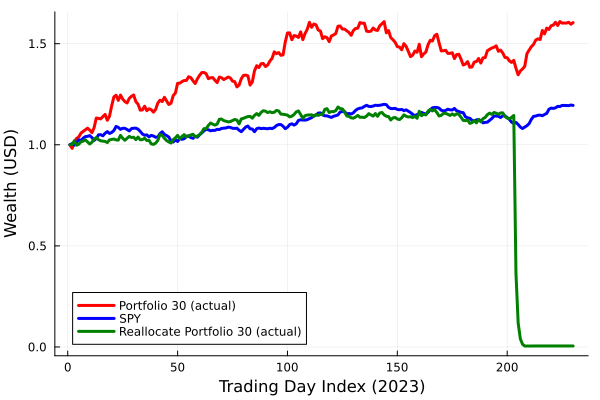

In [325]:
plot((1/portfolio_performance_array_original[1,end]).*portfolio_performance_array_original[:,end], 
    lw=3, c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[1:number_of_trading_days,:volume_weighted_average_price], lw=3, 
    c=:blue, label="SPY")
plot!((1/portfolio_performance_array_reallocate[1,end]).*portfolio_performance_array_reallocate[:,end], lw=3, 
    c=:green, label="Reallocate Portfolio $(portfolio_index) (actual)")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

### Compute `share_volume_array` 

In [330]:
share_volume_array = Array{Float64,2}(undef, number_of_trading_days+1, length(w)+1)

# initial (tday = 0)
share_volume_array[1,1] = 0;
for i ∈ eachindex(my_list_of_tickers)
    share_volume_array[1,i+1] = Nₒ[i]
end

for i ∈ 1:number_of_trading_days
    n_vector = my_results_df[i,:N_new]
    share_volume_array[i+1,1] = i;
    for j ∈ eachindex(n_vector)
        share_volume_array[i+1,j+1] = n_vector[j] |> x-> round(x,digits=3) |> abs
    end
end
header_data = Array{String,1}()
push!(header_data,"index");
[push!(header_data, ticker) for ticker ∈ my_list_of_tickers]
pretty_table(share_volume_array, header=header_data)

## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.